# Qiskit 102: Learning to use Qiskit

The fundamental unit you will primarily work with in Qiskit is the `QuantumCircuit` object. The basic workflow to using Qiskit consists of two stages: build and execute. Building involves making different quantum circuits which represent the problem/algorithm you are solving. Executing takes care of the, well, *execution* of those circuits as a job or set of jobs to be run on either real or simulated hardware. After the jobs have been run, the data is collected and must be postprocessed depending on the desired output.  We can do most of this post-processing using Qiskit Runtime.


## Qiskit Runtime Overview
<img src="./resources/qiskit-runtime.png" alt="Qiskit Runtime Overview" style="width: 1000px;"/>


Qiskit Runtime is a cloud-based quantum computing service developed by IBM. It offers computational primitives to perform foundational quantum computing tasks that use built-in error suppression and mitigation techniques. Primitives can be executed inside of sessions, allowing collections of circuits to be jointly run on a quantum computer without being interrupted by other users’ jobs. The combination of primitives, error suppression / mitigation, and sessions paves the way to efficiently build and execute scalable quantum applications.


---

## Getting Started

The Qiskit packages you will need to get started are:

- `qiskit`
- `qiskit-ibm-runtime`
- `numpy` (optional)
- `matplotlib` (optional)

We'll first walk through the anatomy of a `QuantumCircuit` object and the process of using primitives.

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

import numpy as np

################# MAKE SURE YOUR API TOKEN IS SAVED ##########################

#Store your API token locally (only need to do once)
#QiskitRuntimeService.save_account(channel='ibm_quantum', token='$API_TOKEN')

##############################################################################



In [6]:
#make sure your qiskit version is up to date
import qiskit.tools.jupyter
%qiskit_version_table

## 0.1 Building the circuit 

The basic element needed for your first program is the QuantumCircuit. We begin by creating a QuantumCircuit comprised of two qubits.

In [7]:
# Create a Quantum Circuit acting on a quantum register of two qubits
circ = QuantumCircuit(2)
print(circ)

     
q_0: 
     
q_1: 
     


## 0.2 Adding Gates

We can then add gates to the circuit. We start with a Hadamard gate acting on qubit $0$ and then add a $C_X$ (CNOT) gate using $0$ as the control qubit and $1$ as the target. 

In [8]:
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)

## 0.3 Circuit Visualization

You can visualize your circuit using the `QuantumCircuit.draw()` method, which plots the circuit in the form found in many textbooks.

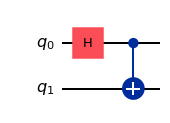

In [9]:
circ.draw('mpl', style="iqp")

In [10]:
#One can also draw this as an ascii drawing
circ.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


A few of the basic gates which can be added to a quantum circuit are the:

* Pauli $X$, $Y$, $Z$ gates - `.x()` `.y()`
* Hadamard $H$ gate 
* $S$ (or $\pi/2$) phase gate
* $T$ (or $\pi/4$) phase gate
* Controlled-NOT (or Controlled-$X$) gate - `.cx`
* Controlled-$H$ gate - `.ch`
* CCX or Toffoli gate - `.ccx`

among many others.  See the documentation for the full list of supported gates.

# 1.0 Using Primitives

There are two main approaches within Qiskit to execute and measure your quantum circuits called `Primitives`.  The first is the `Estimator` which computes the expectation values of observables.  Users generally specify a list of circuits, observables, and a few other optional configurations, with which the program can efficiently evaluate expectation values and variances.  The second is the `Sampler` primitive which with calculate the probabilities (or quasi-probabilities if using error mitigation) of bitstrings from quantum circuits.

Primitives work most effectively when they are supported by both Qiskit and the backend provider. The Qiskit module qiskit.primitives provides the required support on the Qiskit side, and providers like IBM Qiskit Runtime enable access to appropriate backends through native implementations of their own primitives.

We'll learn to use these objects by utilizing a small example circuit which will fully entangle two qubits together and then measure them.

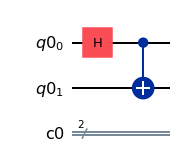

In [11]:
#Create the circuit
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

qc = QuantumCircuit(qr, cr)
# we can also write "qc = QuantumCircuit(2,2)"

#Add the hadamard and CNOT gates to the circuit
qc.h(0)
qc.cx(0, 1)

qc.draw('mpl', style="iqp")

## 1.1 The Estimator Primitive

Let's begin with understanding how to use the `Estimator` primitive.  To start, we'll need to define the observable(s) we want to measure the expectation values of.  They can be constructed from any `BaseOperator` object, like the operators from `qiskit.quantum_info`.  For this example we'll use the `qiskit.quantum_info.SparesPauliOp` object.  We'll construct four observables to measure our entangling circuit, $\langle II +XX -YY + ZZ\rangle$.

In [12]:
# Import the SparesPauliOp class and create our observables variable
from qiskit.quantum_info import SparsePauliOp
 
observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

# Import qiskit primitives
from qiskit.primitives import Estimator

estimator = Estimator()


Once the observable and `Estimator` object are defined, we can go ahead and run our estimation by calling the `qiskit.primitives.Estimator.run()` method.

In [13]:

job = estimator.run(qc, observable)
result = job.result()
print(result)
print(f"Expectation Value of <II+XX-YY+ZZ> = {result.values[0]:.3f}")


EstimatorResult(values=array([4.]), metadata=[{}])
Expectation Value of <II+XX-YY+ZZ> = 4.000


### 1.1.1 Using the Runtime Estimator

A subtle difference here is that there are actually *two* `Estimator` objects in our environment.  One within `qiskit.primitives` and one within our ecosystem package `qiskit-ibm-runtime`.  The Runtime Primitives are best used for submitting jobs to a backend while the Qiskit Primitives are useful for doing sanity checks on your workflows and ensuring everything is working as intended.

We'll now execute this circuit using the Runtime Service.  To do so, we'll need to initialize a `QiskitRuntimeService` object and select a backend to run the circuit on.  For this example we'll use the 127-qubit `ibm_nazca` backend.  We'll then instantiate a new `Estimator` object from the Runtime package. We have two options here: we can instantiate the `Estimator` object with the `backend`, *or* we can start a `Session` that we can send multiple jobs to without waiting in the queue for subsequent jobs, and pass the `Session` object to the `Estimator`.



In [14]:
from qiskit_ibm_runtime import Estimator, Session

#Initialize a QiskitRuntimeService object
service = QiskitRuntimeService()

#We will use the 127-qubit ibm_nazca backend
backend = service.get_backend('ibm_nazca')

# create a Runtime session for efficient execution (optional)
session = Session(service=service, backend=backend)

# estimator = Estimator(backend=backend) 
estimator = Estimator(session=session)

The access your institution has obtained will determine which backends are available to you.  You can list all of your available backends and obtain information about its status, the number of pending jobs, and detailed configuration information.

In [15]:
#Here we can get some status information about the backend
status = backend.status()
is_operational = status.operational
jobs_in_queue = status.pending_jobs
print('Operational?: {} \n Jobs in Queue: {}\n'.format(is_operational, jobs_in_queue))


# We can also obtain some configuration information
config = backend.configuration()
print(64*"#","\nConfiguration for: {}, version: {}".format(config.backend_name, config.backend_version))
print("  Number of Qubits: {}".format(config.n_qubits))
print("  Basis Gates: {}".format(config.basis_gates))
print("  OpenPulse Enabled: {}".format(config.open_pulse))

Operational?: True 
 Jobs in Queue: 17

################################################################ 
Configuration for: ibm_nazca, version: 1.0.15
  Number of Qubits: 127
  Basis Gates: ['ecr', 'id', 'rz', 'sx', 'x']
  OpenPulse Enabled: True



---

Now we'll run our job on the hardware.  We can get also get some information about its status while we wait

In [16]:
job = estimator.run(qc, observable)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Session ID: {job.session_id}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cnme59db4zk00082a4h0
>>> Session ID: cnme59db4zk00082a4h0
>>> Job Status: JobStatus.QUEUED


We can also check on the status on the online platform: [https://quantum-computing.ibm.com/jobs](https://quantum-computing.ibm.com/jobs)

Another useful feature is to be able to pull data from previous jobs you've run if you're running analysis on your results in a separate notebook or python script.  All that's needed is the Job ID

In [ ]:
# Use a job id from a previous result
job = service.job("cncfk64xswgg0087jbj0")
print(f">>> Job Status: {job.status()}")

In [ ]:
#Examine our results once the job has completed
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

***

## 1.2 The Sampler Primitive

Next we'll demonstrate using the `Sampler` primitive (both the `qiskit.primitives` version as well as the managed `qiskit-ibm-runtime` version).  Recall the `Sampler` is primarily useful for when you want to measure (quasi-)probability distributions.  We'll use the same quantum circuit, `qc` which prepares a Bell state (i.e., fully entangle two-qubits together).

First we'll initialize the sampler from `qiskit.primitives` to demonstrate what the output looks like and then add measurement instructions to our circuit.

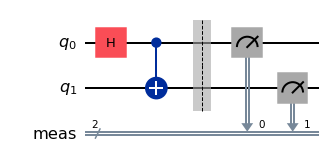

In [17]:
from qiskit.primitives import Sampler

#Instantiate a new Sampler object
sampler = Sampler()


#We'll also need to add measurement
circ = QuantumCircuit(2)

circ.h(0)
circ.cx(0, 1)
# Insert measurements on all qubits
circ.measure_all()
circ.draw('mpl', style='iqp')


In [18]:
# Now run the job and examine the results
sampler_job = sampler.run(circ)
result = sampler_job.result()
print(f"Job Result:\n>>> {result}")
print(f"  > Quasi-probability distribution (integer): {result.quasi_dists[0]}")
print(f"  > Quasi-probability distribution (bits): {result.quasi_dists[0].binary_probabilities(2)}")
print(f"  > Metadata: {result.metadata[0]}")

Job Result:
>>> SamplerResult(quasi_dists=[{0: 0.5, 3: 0.5}], metadata=[{}])
  > Quasi-probability distribution (integer): {0: 0.5, 3: 0.5}
  > Quasi-probability distribution (bits): {'00': 0.4999999999999999, '11': 0.4999999999999999}
  > Metadata: {}



---


Next we'll use the Runtime Sampler to run our circuit on a backend.  Recall that we still need to specify an `IBMBackend` object through the `QisktiRuntimeService`.

In [19]:
from qiskit_ibm_runtime import Sampler
 
#Initialize a QiskitRuntimeService object
service = QiskitRuntimeService()

#We will use the 127-qubit ibm_nazca backend
backend = service.get_backend('ibm_nazca')

# sampler = Sampler(backend=backend)
sampler = Sampler(session=session)

In [20]:
job = sampler.run(circ)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Session ID: {job.session_id}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cnme5geb4zk00082a4hg
>>> Session ID: cnme59db4zk00082a4h0
>>> Job Status: JobStatus.QUEUED


We can also obtain a previous result in the same way as the `Estimator`.

In [21]:
# Use a job id from a previous result
job = service.job("cncfm89hga30008f2660")
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.DONE


In [22]:
result = job.result()
print(f"Job Result:\n>>> {result}")
print(f"  > Quasi-probability distribution (integer): {result.quasi_dists[0]}")
print(f"  > Quasi-probability distribution (bits): {result.quasi_dists[0].binary_probabilities(2)}")
print(f"  > Metadata: {result.metadata[0]}")

Job Result:
>>> SamplerResult(quasi_dists=[{0: 0.500216756192343, 1: 0.018130479836529, 2: -0.009745479238165, 3: 0.491398243209293}], metadata=[{'shots': 4000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.3906290541317785, 'readout_mitigation_time': 0.036765546072274446}])
  > Quasi-probability distribution (integer): {0: 0.500216756192343, 1: 0.018130479836529, 2: -0.009745479238165, 3: 0.491398243209293}
  > Quasi-probability distribution (bits): {'00': 0.5002167561923428, '01': 0.018130479836528622, '10': -0.009745479238164975, '11': 0.49139824320929343}
  > Metadata: {'shots': 4000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.3906290541317785, 'readout_mitigation_time': 0.036765546072274446}


We're also able to visualize the probability distribution of this circuit on a histogram.  Plotting this gives us a quick visual tool to help us understand what the states with the highest measurement probability are. 

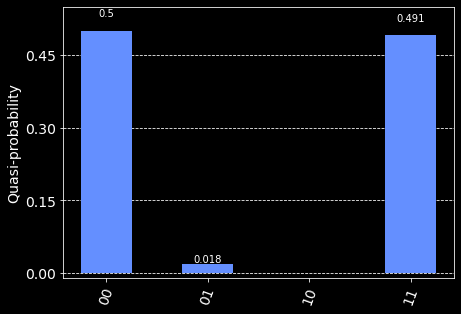

In [25]:
from qiskit.visualization import plot_distribution

import matplotlib.pyplot as plt
plt.style.use('dark_background')

#plot_distribution(result.quasi_dists[0])
plot_distribution(result.quasi_dists[0].binary_probabilities(2))

---

## 2. Transpilation & Error Mitigation

Oftentimes, the quantum circuits constructed for utility scale algorithms are not well optimized to run on noisy quantum hardware.  In fact, it may even be important to post-process your results using error mitigation techniques.  Fortunately, there are a few ways to implement both error mitigation as well as optimizations of your quantum circuits.

The first is to simply set a few Runtime configuration options; specifically the `optimization_level` and `resilience_level`.  These are both managed and included in a Runtime Primitive using the `Options` object.

The options for `optimization_level` are:

| Optimization Level | Estimator & Sampler |
| :--- | :--- |
| 0 | No optimization: typically used for hardware characterization or debugging <br />    - Basis translation <br /> - Layout (`TrivialLayout`: virtual -> physical)  <br /> - Routing: `StochasticSwap` |
| 1, 2, 3 | Light optimization: (TODO: update this w/ current docs) <br /> - Layout (trivial → vf2 → SabreLayout if routing is required) <br /> - Routing (SabreSwap if needed) <br /> - 1Q gate optimization <br /> - Error suppression: dynamical decoupling |


And the options for `resilience_level` are different between the `Sampler` and `Estimator` primitives

| Resilience Level | Definition | Estimator | Sampler |
| :--- | :--- | :--- | :---
|0 | No mitigation	| None | None |
|1 [Default] |	Minimal mitigation costs: Mitigate error associated with readout errors | Twirled Readout Error eXtinction (TREX interpreted-text readout errors )	| M3 |
| 2 | Medium mitigation costs. Typically reduces bias in estimators, but is not guaranteed to be zero bias. | Zero Noise Extrapolation (ZNE interpreted-text) |	- |
| 3| Heavy mitigation with layer sampling. Theoretically expected to deliver zero bias estimators. | Probabilistic Error cancelation (PEC interpreted-text)	| - |


Let's look at a quick example

In [20]:
from qiskit_ibm_runtime import Options


# To set our resilience and optimization level we need to create this `Options` object
options = Options()
options.resilience_level = 2
options.optimization_level = 3

In [22]:
# We'll prepare the same example circuit as before
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

qc = QuantumCircuit(qr, cr)
# we can also write "qc = QuantumCircuit(2,2)"

#Add the hadamard and CNOT gates to the circuit
qc.h(0)
qc.cx(0, 1)


# We'll also instantiate a new Runtime Estimator() object
# estimator = Estimator(options=options, backend=backend)
estimator = Estimator(options=options, session=session)

# and use the same observable as before
observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])


In [23]:
job = estimator.run(circuits=qc, observables=observable)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Session ID: {job.session_id}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cncfmyvnekzg008nr2rg
>>> Session ID: cncfk64xswgg0087jbj0
>>> Job Status: JobStatus.QUEUED


In [ ]:
# Use a job id from a previous result
job = service.job("cn9ee48q2k7g0088qvzg")
print(f">>> Job Status: {job.status()}")

In [ ]:
#Examine our results once the job has completed
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

## Transpilation Stages

TODO: update this with content from newer docs.
The next approach to optimizing our quantum circuits is to use Qiskit's `transpiler` features.  This includes both a preset approach to optimization as well as functionality to use a custom pipeline.  The quick and easy way we'll go over is to use the `qiskit.compiler.transpile()` method.  This function will take quite a few parameters as input, but the only *required* argument(s) are the circuit(s) to be optimized.  Once the `transpile()` function is called, several stages of optimization are prepared:

1. `init` - This pass runs any initial passes that are required before we start embedding the circuit to the backend.  This typically involves unrolling custom instructions and converting the circuit to all single- and two-qubit gates. (By default this will just validate the circuit instructions and translate multi-qubit gates into 1 and 2 qubit gates)
1. `layout` - This pass applies a *layout*, mapping/assigning the virtual qubits in your circuit to the physical qubits of a backend.
1. `routing` - This pass runs after a layout has been applied and will inject gates (i.e., SWAPs) in the original circuit in order to make it compatible with the backend's connectivity/coupling map.
1. `translation` - This pass translates the gates in the circuit to the backend's basis set of instructions.
1. `optimization` - This pass runs an optimization loop to find more efficient decompositions of your quantum circuit until a condition is met (such as a fixed depth).
1. `scheduling` - This pass is for any hardware-aware optimizations that improve the efficiency of the executed microwave pulse instructions.

## Init stage

This first stage does very little by default and is primarily useful if you want to include your own initial optimizations.  Because most layout and routing algorithms are only designed to work with single- and two-qubit gates, this stage is also used to translate any gates that operate on more than two qubits into gates that only operate on one or two qubits.


## Layout stage
In the next stage, we start considering the layout or connectivity of the backend a circuit will be sent to.  In general, quantum circuits are abstract entities whose qubits are "virtual" or "logical" representations of actual qubits used in computations.  To execute a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device is necesary.  This mapping is stored as a `Layout` object.


![Qubit mapping](./resources/layout-mapping.png)

The choice of mapping is extremely important for minimizing the number of SWAP operations needed to map the input circuit onto the device topology and ensure the most well-calibrated qubits are used.  Due to the improtance of this stage, the preset pass managers try a few different methods to find the best layout.  Typically this involves two steps: first, try to find a "perfect" layout (a layout that does not require any SWAP operations), and then, a heuristic pass that tries to find the best layout to use if a perfect layout cannot be found.  There are two `Passes` typically used for this first step:

- `TrivialLayout`: Naively maps each virtual qubit to the same numbered physical qubit on the device (i.e. [`0`,`1`,`1`,`3`] -> [`0`,`1`,`1`,`3`]).  This is historical behavior only used in `optimzation_level=1` to try to find a perfect layout.  If it fails, `VF2Layout` is tried next.
- `VF2Layout`: This is an `AnalysisPass` that selects an ideal layout by treating this stage as a subgraph isomorphism problem, solved by the VF2++ algorithm.  If more than one layout is found, a scoring heuristic is run to select the mapping with the lowest average error.

Then for the heuristic stage, two passes are used by default:

- `DenseLayout`: Findsthe sub-graph of the device with the greatest connectivity and that has the same number of qubits as the circuit.  (Used for optimization level 1 if there are control flow operations (such as IfElseOp) present in the circuit).
- `SabreLayout`: This pass selects a layout by starting from an initial random layout and repeatedly running the `SabreSwap` algorithm.  This pass is only used in optimization levels 1, 2, and 3 if a perfect layout isn't found via the `VF2Layout` pass.  For more details on this algorithm, refer to the paper: [arXiv:1809.02573](https://arxiv.org/abs/1809.02573)


## Routing stage

In order to implement a two-qubit gate between qubits that are not directly connected on a quantum device, one or more SWAP gates must be inserted into the circuit to move the qubit states around until they are adjacent on the device gate map.  Each SWAP gate represents an expensive and noisy operation to perform.  Thus, finding the minimum number of SWAP gates needed to map a circuit onto a given device is an important step in the whole transpilation process.  For efficiency, this stage is typically computed alongside the Layout stage by default, but they are logically distinct from one another.  The *Layout* stage selects the hardware qubits to be used, while the *Routing* stage inserts the appropriate amount of SWAP gates in order to execute the circuits using the selected layout.

However this may come as no surprise that there's no free lunch here and that finding the optimal SWAP mapping is hard.  In fact, it is an NP-hard problem, and is thus prohibitively expensive to compute for all but the smallest quantum devices and input circuits.  To work around this, Qiskit uses a stochastic heuristic algorithm called `SabreSwap` to compute a good, but not necessarily optimal, SWAP mapping. The use of a stochastic method means that the circuits generated by `transpile()` are not guaranteed to be the same over repeated runs.  Indeed, running the same circuit repeatedly results in a distribution of circuit depths and gate counts at the output.  It is for this reason that many users choose to run the routing function (or the entire `StagedPassManager`) many times and select the lowest-depth circuits from the distribution of outputs.

It's also important to point out here that the `SabreSwap` algorithm is different from the larger `SabreLayout` method in the previous stage.  By default, `SabreLayout` runs both layout and routing, and returns the transformed circuit.  This is done for a few particular technical reasons specified in the pass's [API reference page](../api/qiskit/qiskit.transpiler.passes.SabreLayout). 

## Translation stage

When writing a quantum circuit, you are free to use any quantum gate (unitary operation) that you like, along with a collection of non-gate operations such as qubit measurement or reset instructions.  However, most quantum devices only natively support a handful of quantum gate and non-gate operations. This stage of the preset `PassManagers`  translates (or *unrolls*) the gates specified in a circuit to the native basis gates of a specified backend.  This is an important step, as it allows the circuit to be executed by the backend, but typically leads to an increase in the depth and number of gates.

There two special cases which are especially important to highlight, and which help illustrate what this stage does:

1. If a SWAP gate is not a native gate to the target backend, this requires three CNOT gates:

['rz', 'sx', 'x', 'ecr', 'measure', 'delay']


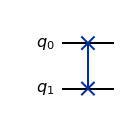

In [24]:
from qiskit.providers.fake_provider import FakeSherbrooke
from qiskit import QuantumCircuit

backend = FakeSherbrooke()
print(backend.operation_names)
qc = QuantumCircuit(2)
qc.swap(0, 1)
qc.draw('mpl', style='iqp')

In [ ]:
qc.decompose().draw('mpl')

As a product of three CNOT gates, SWAPs are expensive operations to perform on noisy quantum devices.  However, such operations are usually necessary for embedding a circuit into the limited gate connectivities of many devices.  Thus, minimizing the number of SWAP gates in a circuit is a primary goal in the process of transpilation.

2. A Toffoli, or controlled-controlled-not gate (`ccx`), is a three-qubit gate.  Given that our basis gate set includes only single- and two-qubit gates, this operation must be decomposed.  However, it is quite costly:

In [ ]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.draw('mpl')

In [ ]:
qc.decompose().draw('mpl')

For every Toffoli gate in a quantum circuit, the hardware may execute up to six CNOT gates and a handful of single-qubit gates.  From this example, it should be clear that any algorithm that makes use of multiple Toffoli gates will end up as a circuit with large depth and will therefore be appreciably affected by noise.

## Optimization stage

This stage centers around decomposing quantum circuits into the basis gate set of the target device, and must fight against the increased depth from the layout and routing stages.  Fortunately, there are many routines for optimizing circuits by either combining or eliminating gates.  In some cases, these methods are so effective that the output circuits have lower depth than the inputs, even after layout and routing to the hardware topology.  In other cases, not much can be done, and the computation may be difficult to perform on noisy devices.  This stage is where the various optimization levels begin to differ.

- For `optimization_level=1`, this stage prepares the [`Optimize1qGatesDecomposition`](../api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition) and [`CXCancellation`](../api/qiskit/qiskit.transpiler.passes.CXCancellation), which combine chains of single-qubit gates and cancel any back-to-back CNOT gates.
- For `optimization_level=2`, this stage uses the [`CommutativeCancellation`](../api/qiskit/qiskit.transpiler.passes.CommutativeCancellation) pass instead of `CXCancellation`, which removes redundant gates by exploiting commutation relations.
- For `optimization_level=3`, this stage prepares the following passes:
  - [`Collect2qBlocks`](../api/qiskit/qiskit.transpiler.passes.Collect2qBlocks)
  - [`ConsolidateBlocks`](../api/qiskit/qiskit.transpiler.passes.ConsolidateBlocks)
  - [`UnitarySynthesis`](../api/qiskit/qiskit.transpiler.passes.UnitarySynthesis)
  - [`Optimize1qGateDecomposition`](../api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition)
  - [`CommutativeCancellation`](../api/qiskit/qiskit.transpiler.passes.CommutativeCancellation)


Additionally, this stage also executes a few final checks to make sure that all instructions in the circuit are composed of the basis gates available on the target backend.

## Scheduling

This last stage is only run if it is explicitly called for (similar to the Init stage) and does not run by default (though a method can be specified by setting the `scheduling_method` argument when calling `transpile()`).  The scheduling stage is typically used once the circuit has been translated to the target basis, mapped to the device, and optimized.  These passes focus on accounting for all the idle time in a circuit.  At a high level, the scheduling pass can be thought of as explicitly inserting delay instructions to account for the idle time between gate executions and to inspect how long the circuit will be running on the backend.  Scheduling a circuit involves two parts: analysis and constraint mapping, followed by a padding pass.  The first part requires running a scheduling analysis pass (by default this is [`ALAPSchedulingAnalysis`](../api/qiskit/qiskit.transpiler.passes.ALAPScheduleAnalysis)), which analyzes the circuit and records the start time of each instruction in the circuit into a schedule.  Once the circuit has an initial schedule, additional passes can be run to account for any timing constraints on the target backend.  Finally, a padding pass, such as [`PadDelay`](../api/qiskit/qiskit.transpiler.passes.PadDelay) or [`PadDynamicalDecoupling`](../api/qiskit/qiskit.transpiler.passes.PadDynamicalDecoupling) can be executed.